In [1]:
!pip install tensorflow==2.15.0


  Obtaining dependency information for tensorflow==2.15.0 from https://files.pythonhosted.org/packages/93/21/9b035a4f823d6aee2917c75415be9a95861ff3d73a0a65e48edbf210cec1/tensorflow-2.15.0-cp311-cp311-win_amd64.whl.metadata
  Using cached tensorflow-2.15.0-cp311-cp311-win_amd64.whl.metadata (3.6 kB)
  Obtaining dependency information for tensorflow-intel==2.15.0 from https://files.pythonhosted.org/packages/4c/48/1a5a15517f18eaa4ff8d598b1c000300b20c1bb0e624539d702117a0c369/tensorflow_intel-2.15.0-cp311-cp311-win_amd64.whl.metadata
  Using cached tensorflow_intel-2.15.0-cp311-cp311-win_amd64.whl.metadata (5.1 kB)
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/a2/ad/e0d3c824784ff121c03cc031f944bc7e139a8f1870ffd2845cc2dd76f6c4/absl_py-2.1.0-py3-none-any.whl.metadata
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Obtaining dependency information for astunparse>=1.6.0 from https://files.pythonhosted.org/packages/2b/03/13dd

In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.inception_v3 import preprocess_input
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random

In [3]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
DATASET_DIR = r'C:\Users\kisha\OneDrive\Desktop\archive (5)\UTKFace'

In [4]:
def categorize_age(age):
    if age >= 100:
        return 19  
    return age // 5

In [5]:
def extract_label_from_path(path):
    filename = os.path.basename(path)
    parts = filename.split('_')
    age = categorize_age(int(parts[0]))
    gender = int(parts[1])
    return age, gender

In [6]:
image_paths = []
ages = []
genders = []
print("Files in dataset directory:", os.listdir(DATASET_DIR))
for filename in os.listdir(DATASET_DIR):
    if filename.endswith('.jpg'):
        path = os.path.join(DATASET_DIR, filename)
        age, gender = extract_label_from_path(path)
        image_paths.append(path)
        ages.append(age)
        genders.append(gender)

print("Number of images found:", len(image_paths))
if len(image_paths) == 0:
    raise ValueError("No images found in the dataset directory. Please check the directory and file extensions.")

Files in dataset directory: ['100_0_0_20170112213500903.jpg.chip.jpg', '100_0_0_20170112215240346.jpg.chip.jpg', '100_1_0_20170110183726390.jpg.chip.jpg', '100_1_0_20170112213001988.jpg.chip.jpg', '100_1_0_20170112213303693.jpg.chip.jpg', '100_1_0_20170112215032192.jpg.chip.jpg', '100_1_0_20170117195420803.jpg.chip.jpg', '100_1_0_20170119212053665.jpg.chip.jpg', '100_1_2_20170105174847679.jpg.chip.jpg', '100_1_2_20170112213615815.jpg.chip.jpg', '100_1_2_20170112222336458.jpg.chip.jpg', '101_0_0_20170112213500903.jpg.chip.jpg', '101_1_2_20170105174739309.jpg.chip.jpg', '103_0_2_20170112213001988.jpg.chip.jpg', '105_0_0_20170112213001988.jpg.chip.jpg', '105_1_0_20170112213001988.jpg.chip.jpg', '105_1_0_20170112213021902.jpg.chip.jpg', '105_1_0_20170112213507183.jpg.chip.jpg', '105_1_1_20170112213303693.jpg.chip.jpg', '10_0_0_20161220222308131.jpg.chip.jpg', '10_0_0_20170103200329407.jpg.chip.jpg', '10_0_0_20170103200522151.jpg.chip.jpg', '10_0_0_20170103233459275.jpg.chip.jpg', '10_0_0_2

In [7]:
data = pd.DataFrame({
    'image_path': image_paths,
    'age': ages,
    'gender': genders
})

In [8]:
data['age'] = data['age'].apply(lambda x: to_categorical(x, num_classes=20).tolist())

print("DataFrame head:", data.head())


DataFrame head:                                           image_path  \
0  C:\Users\kisha\OneDrive\Desktop\archive (5)\UT...   
1  C:\Users\kisha\OneDrive\Desktop\archive (5)\UT...   
2  C:\Users\kisha\OneDrive\Desktop\archive (5)\UT...   
3  C:\Users\kisha\OneDrive\Desktop\archive (5)\UT...   
4  C:\Users\kisha\OneDrive\Desktop\archive (5)\UT...   

                                                 age  gender  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       0  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       0  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       1  
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       1  
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...       1  


In [9]:
train_df, val_df = train_test_split(data, test_size=0.2, random_state=42)
print("Training set size:", len(train_df))
print("Validation set size:", len(val_df))

Training set size: 18966
Validation set size: 4742


In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col=['gender', 'age'],
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='multi_output'
)
val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col=['gender', 'age'],
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='multi_output'
)

Found 18966 validated image filenames.
Found 4742 validated image filenames.


In [10]:
def create_inceptionv3_model():
    base_model = InceptionV3(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
    for layer in base_model.layers[:-30]:  # Fine-tune the last 30 layers
        layer.trainable = False
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    gender_output = layers.Dense(1, activation='sigmoid', name='gender_output')(x)
    age_output = layers.Dense(20, activation='softmax', name='age_output')(x)
    model = models.Model(inputs=base_model.input, outputs=[gender_output, age_output])
    model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
                  loss={'gender_output': 'binary_crossentropy', 'age_output': 'categorical_crossentropy'},
                  metrics={'gender_output': 'accuracy', 'age_output': 'accuracy'})
    return model

In [11]:
inceptionv3_model = create_inceptionv3_model()

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)


In [12]:
history = inceptionv3_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=[lr_scheduler]
)
results = inceptionv3_model.evaluate(val_generator)
print("Validation Loss, Validation Gender Accuracy, Validation Age Accuracy:", results)

Epoch 1/15


593/593 [==============================] - 1325s 2s/step - loss: 2.7029 - gender_output_loss: 0.4751 - age_output_loss: 2.2277 - gender_output_accuracy: 0.7734 - age_output_accuracy: 0.2830 - val_loss: 2.3327 - val_gender_output_loss: 0.3507 - val_age_output_loss: 1.9820 - val_gender_output_accuracy: 0.8461 - val_age_output_accuracy: 0.3212 - lr: 1.0000e-04
Epoch 2/15
593/593 [==============================] - 1018s 2s/step - loss: 2.4603 - gender_output_loss: 0.4071 - age_output_loss: 2.0533 - gender_output_accuracy: 0.8109 - age_output_accuracy: 0.3107 - val_loss: 2.2122 - val_gender_output_loss: 0.3319 - val_age_output_loss: 1.8802 - val_gender_output_accuracy: 0.8431 - val_age_output_accuracy: 0.3469 - lr: 1.0000e-04
Epoch 3/15
593/593 [==============================] - 1021s 2s/step - loss: 2.3684 - gender_output_loss: 0.3850 - age_output_loss: 1.9834 - gender_output_accuracy: 0.8227 - age_output_accuracy: 0.3206 - val_loss: 2.1550 - val_gender_output_loss: 0.3037 - v

In [13]:
inceptionv3_model.save("IV35_Enhanced3.h5")

C:\Users\kisha\anaconda5\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


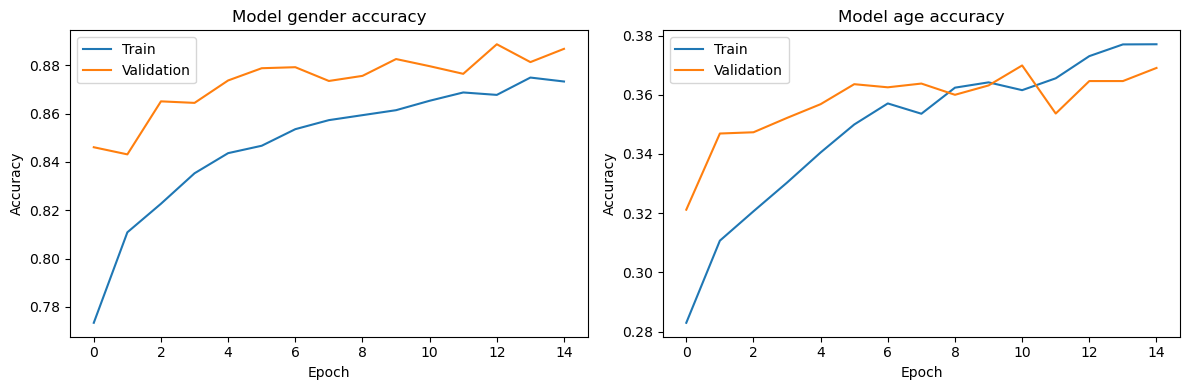

In [14]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['gender_output_accuracy'])
    plt.plot(history.history['val_gender_output_accuracy'])
    plt.title('Model gender accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['age_output_accuracy'])
    plt.plot(history.history['val_age_output_accuracy'])
    plt.title('Model age accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

1/1 [==============================] - 0s 82ms/step


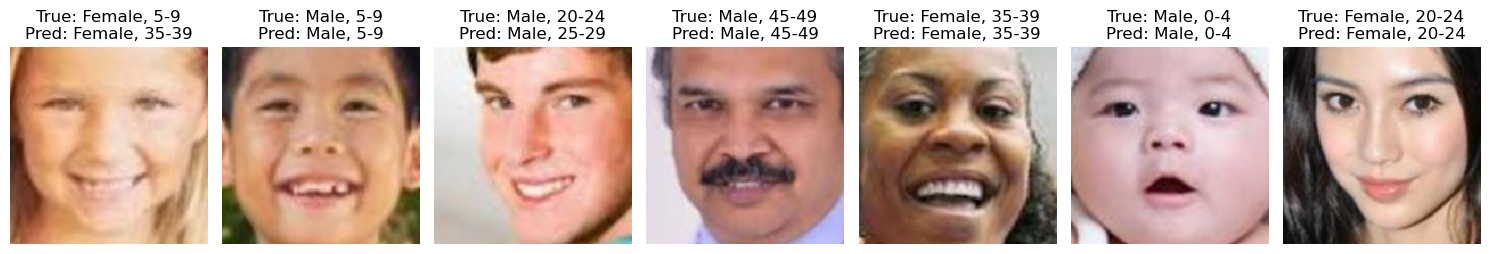

In [18]:
def display_sample_predictions(model, data_df, num_samples=5):
    sample_indices = random.sample(range(len(data_df)), num_samples)
    sample_data = data_df.iloc[sample_indices]

    plt.figure(figsize=(15, 5))
    for i, (index, row) in enumerate(sample_data.iterrows()):
        img_path = row['image_path']
        true_age = np.argmax(row['age'])
        true_gender = "Male" if row['gender'] == 0 else "Female"
        
        img_array = load_and_preprocess_image(img_path)
        predictions = model.predict(img_array)
        
        predicted_gender_prob = predictions[0][0][0]
        predicted_age = np.argmax(predictions[1][0])
        
        predicted_gender = "Male" if predicted_gender_prob <= 0.5 else "Female"
        
        img = image.load_img(img_path, target_size=IMG_SIZE)
        
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(f"True: {true_gender}, {true_age*5}-{true_age*5 + 4}\nPred: {predicted_gender}, {predicted_age*5}-{predicted_age*5 + 4}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

display_sample_predictions(inceptionv3_modelsaved, val_df, num_samples=7)



1/1 [==============================] - 2s 2s/step
Predicted Gender: Male (Probability: 0.00)
Predicted Age Category: 45-49


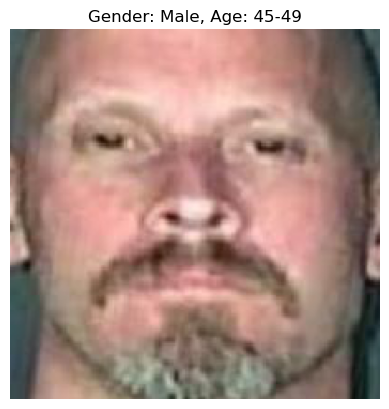

In [12]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
MODEL_PATH="IV35_Enhanced.h5"
def load_and_preprocess_image(img_path):
    try:
        img = image.load_img(img_path, target_size=IMG_SIZE)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        return img_array
    except Exception as e:
        print(f"Error loading or preprocessing image: {e}")
        return None
def predict_image(model, img_path):
    img_array = load_and_preprocess_image(img_path)
    if img_array is None:
        return
    
    predictions = model.predict(img_array)
    gender_prob = predictions[0][0][0]
    age_probabilities = predictions[1][0]
    
    gender = "Male" if gender_prob <= 0.5 else "Female"
    age_category = np.argmax(age_probabilities)   
    print(f"Predicted Gender: {gender} (Probability: {gender_prob:.2f})")
    print(f"Predicted Age Category: {age_category*5}-{age_category*5 + 4}")
  
    img = image.load_img(img_path, target_size=IMG_SIZE)
    plt.imshow(img)
    plt.title(f"Gender: {gender}, Age: {age_category*5}-{age_category*5 + 4}")
    plt.axis('off')
    plt.show()
inceptionv3_modelsaved = load_model(MODEL_PATH)
# Replace with your test image path
test_image_path = r"C:\Users\kisha\OneDrive\Desktop\archive (5)\UTKFace\49_0_0_20170117153916924.jpg.chip.jpg"
predict_image(inceptionv3_modelsaved, test_image_path)